In [1]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 9.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.estimators.CITests import chi_square
import networkx as nx
from pgmpy.estimators import BicScore ,K2Score, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianNetwork
import numpy as np
from pgmpy.inference import VariableElimination, ApproxInference
from pgmpy.base import DAG
from pgmpy.metrics import correlation_score
from pgmpy.sampling import BayesianModelSampling
from time import time

In [6]:
df = pd.read_csv("./data/cleaning_dataset.csv")

## PC Algorithm

 The independencies
        in the dataset are identified by doing statistical independece test. This
        method returns a DAG/PDAG structure which is faithful to the independencies
        implied by the dataset.
<br>
Types of test:
<ul>
<li> "chi_square": Uses the Chi-Square independence test. This works only for discrete datasets.
<li>"pearsoner": Uses the pertial correlation based on pearson correlation coefficient to test independence. This works only for continuous datasets.


### Correlation Matrix chi square
In this matrix we have chi square between variables, a very low value indicate dipendence.

In [7]:
cols = df.columns
p_values = np.zeros((len(cols), len(cols)))
for first_index, first_col_val in enumerate(cols): 
    for second_index, second_col_val in enumerate(cols):
        if first_index != second_index:
            (chi, p_value, dof) = chi_square(first_col_val, second_col_val, [], df, False)
            p_values[first_index, second_index] = p_value

display(pd.DataFrame(p_values, columns=cols, index=cols).apply(np.log))

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PerformanceRating,TotalWorkingYears,WorkLifeBalance
Age,-inf,-22.740696,-1.039148,-2.791456,-51.975803,-209.963969,-0.072464,-6.107392,-122.459167,-1.295151,-0.257330,-355.619684,-0.065379
Attrition,-22.740696,-inf,-12.091207,-4.223994,-0.606006,-34.237255,-7.494202,-23.081838,-27.270011,-46.255236,-0.009975,-40.851214,-6.935569
BusinessTravel,-1.039148,-12.091207,-inf,-0.577524,-0.532532,-0.966097,-0.661752,-2.192671,-2.205608,-1.426898,-0.531619,-0.129714,-0.069215
DistanceFromHome,-2.791456,-4.223994,-0.577524,-inf,-0.086128,-1.639176,-0.136519,-1.157242,-0.807594,-1.582876,-2.709210,-1.675896,-0.064895
Education,-51.975803,-0.606006,-0.532532,-0.086128,-inf,-16.288140,-1.002704,-0.482621,-16.434348,-0.903363,-0.438111,-17.477097,-0.166011
JobLevel,-209.963969,-34.237255,-0.966097,-1.639176,-16.288140,-inf,-0.062962,-3.386753,-inf,-0.059707,-0.089660,-681.598728,-0.278890
JobSatisfaction,-0.072464,-7.494202,-0.661752,-0.136519,-1.002704,-0.062962,-inf,-0.188194,-0.246965,-1.213438,-1.347376,-0.295545,-0.384024
MaritalStatus,-6.107392,-23.081838,-2.192671,-1.157242,-0.482621,-3.386753,-0.188194,-inf,-2.197425,-0.408361,-0.097899,-5.526637,-0.620408
MonthlyIncome,-122.459167,-27.270011,-2.205608,-0.807594,-16.434348,-inf,-0.246965,-2.197425,-inf,-0.023468,-0.883640,-373.938535,-1.235510
OverTime,-1.295151,-46.255236,-1.426898,-1.582876,-0.903363,-0.059707,-1.213438,-0.408361,-0.023468,-inf,-0.072064,-1.257106,-0.699757


This is a ordered list of r.v. to build the network.

In [8]:
orderd_list = ['Age','Education','MaritalStatus','DistanceFromHome','BusinessTravel',
               'WorkLifeBalance','TotalWorkingYears','JobLevel','OverTime','JobSatisfaction',
               'PerformanceRating','MonthlyIncome','Attrition']

The first model is based on PC Algorithm, the variant used is "stable" because it returns the same results for every run doing more statistical tests

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/base/DAG.py:1198: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  + "oriented arbitrarily."


DAG with 8 nodes and 7 edges


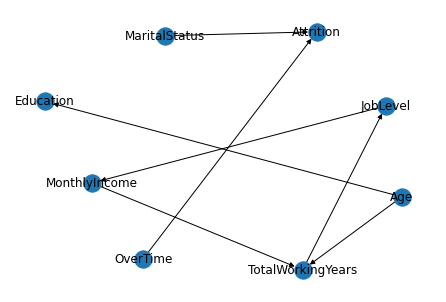

In [9]:
pcest = PC(df)
pcmodel = pcest.estimate(variant = 'stable',max_cond_vars=4, significance_level=0.05)
print(pcmodel)
nx.draw(pcmodel, with_labels=True)

## Hill Climbing
To improve the structure learning, it has been used __Hill Climbing__ , it uses an heuristic sarch.
For this Algorithm we can use different score to search variables dipendences. The score used are:
<ul>
<li>__BicScore__is a log-likelihood score with an additional penalty for network complexity, to avoid overfitting.The score measures how well a model is able to describe the given data set. The BIC scoring function is defined as:<br>
Φ(B|T) = LL(B|T) - f(N) |B| <br> where: <ul>
<li> B is the Bayesian Network;
<li>T is the given Data;
<li>LL is the log-likelihood of the Bayesian Network given the data;
<li> N is the number of records in the dataset
<li> |B| is the number of parameter in the network (network complexity).
<li> f(N) is the penalty function <br>
The lower BIC score signals a better model. 
</ul>
<li>__K2 score__ is based on Dirichlet prior probability.
<br>
The target was to study the difference between the networks that used different score


### HILL CLIMBING BAYESIAN NETWORK USING BIC SCORE


  0%|          | 0/1000000 [00:00<?, ?it/s]

-16957.62954195102
[('Age', 'Education'), ('Attrition', 'OverTime'), ('Attrition', 'MaritalStatus'), ('Attrition', 'BusinessTravel'), ('JobLevel', 'TotalWorkingYears'), ('JobLevel', 'Attrition'), ('MonthlyIncome', 'JobLevel'), ('TotalWorkingYears', 'Age')]


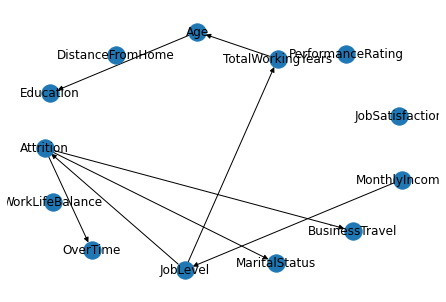

In [10]:
est = HillClimbSearch(df)
HC_first = est.estimate(scoring_method=BicScore(df))
nx.draw(HC_first, with_labels=True)
print(BicScore(df).score(HC_first))
print((HC_first.edges()))

### Hill Climbing using K2Score

  0%|          | 0/1000000 [00:00<?, ?it/s]

-16919.66087345071
[('Age', 'Education'), ('Attrition', 'OverTime'), ('Attrition', 'TotalWorkingYears'), ('Attrition', 'MaritalStatus'), ('Attrition', 'BusinessTravel'), ('Attrition', 'JobSatisfaction'), ('Attrition', 'WorkLifeBalance'), ('JobLevel', 'MonthlyIncome'), ('TotalWorkingYears', 'JobLevel'), ('TotalWorkingYears', 'Age')]


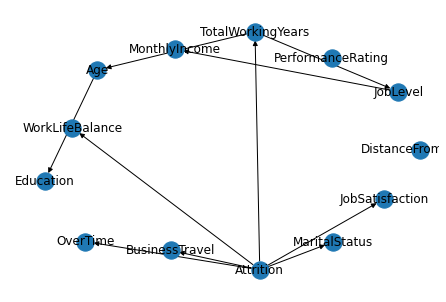

In [11]:
est = HillClimbSearch(df)
HC_firstK2 = est.estimate(scoring_method=K2Score(df))
nx.draw(HC_firstK2, with_labels=True)
print(K2Score(df).score(HC_firstK2))
print(HC_firstK2.edges)

### Observation

Observing the 2 previous networks, we can notice that the Algorithm does not find lots of correlations between variables, it is caused because the dataset is small and does not provide much information about correlations between variables. <br>In addition we can observe that using BicScore, the Algorithm finds some correlations between: Attrition, MaritalStatus, JobLevel, BusinessTravel and MonthlyIncome; instead using K2Score the Algorithm finds a lot of correlations between: Attrition and others variables.<br>
Furthermore, both networks have some nodes without edges, to solve this problem in the next sections we try to add some information to the network structure.



## Using fixed edges

To improve network structure we try to use particular fixed edges. In particular, we add edges to the nodes where the Algorithm cannot find correlation (observing previous models).  
For example, we add information to DistanceFromHome,WorkLifeBalance and PerformanceRating.

In [12]:
edges = [("DistanceFromHome","WorkLifeBalance"),
         ("DistanceFromHome","JobSatisfaction"),
         ("WorkLifeBalance","Attrition"),
         ("MaritalStatus","WorkLifeBalance"),
         ("PerformanceRating","MonthlyIncome"),
         ("JobSatisfaction","PerformanceRating"),
         ("OverTime","Attrition"),
         ("BusinessTravel","WorkLifeBalance"),
        ]
print(len(edges))

8


In [13]:
pos = {
     "MaritalStatus":(1,5),
     "DistanceFromHome":(3,5),
     "Education":(4,5),
     "Age":(5,5),
     "OverTime":(1,1),
     "BusinessTravel":(1.8,3),
     "WorkLifeBalance":(2.8,3),
     "JobSatisfaction":(4,3),
     "JobLevel":(5,3),
     "TotalWorkingYears":(6,3),
     "PerformanceRating":(4.5,1),
     "MonthlyIncome":(5,-1),
     "Attrition":(3,1),
}

## Using fixed edges, Hill Climbing Bic Score

  0%|          | 0/1000000 [00:00<?, ?it/s]

{('JobLevel', 'TotalWorkingYears'), ('MonthlyIncome', 'JobLevel'), ('TotalWorkingYears', 'Age'), ('Age', 'Education'), ('Attrition', 'MonthlyIncome')}
-17290.818984738587


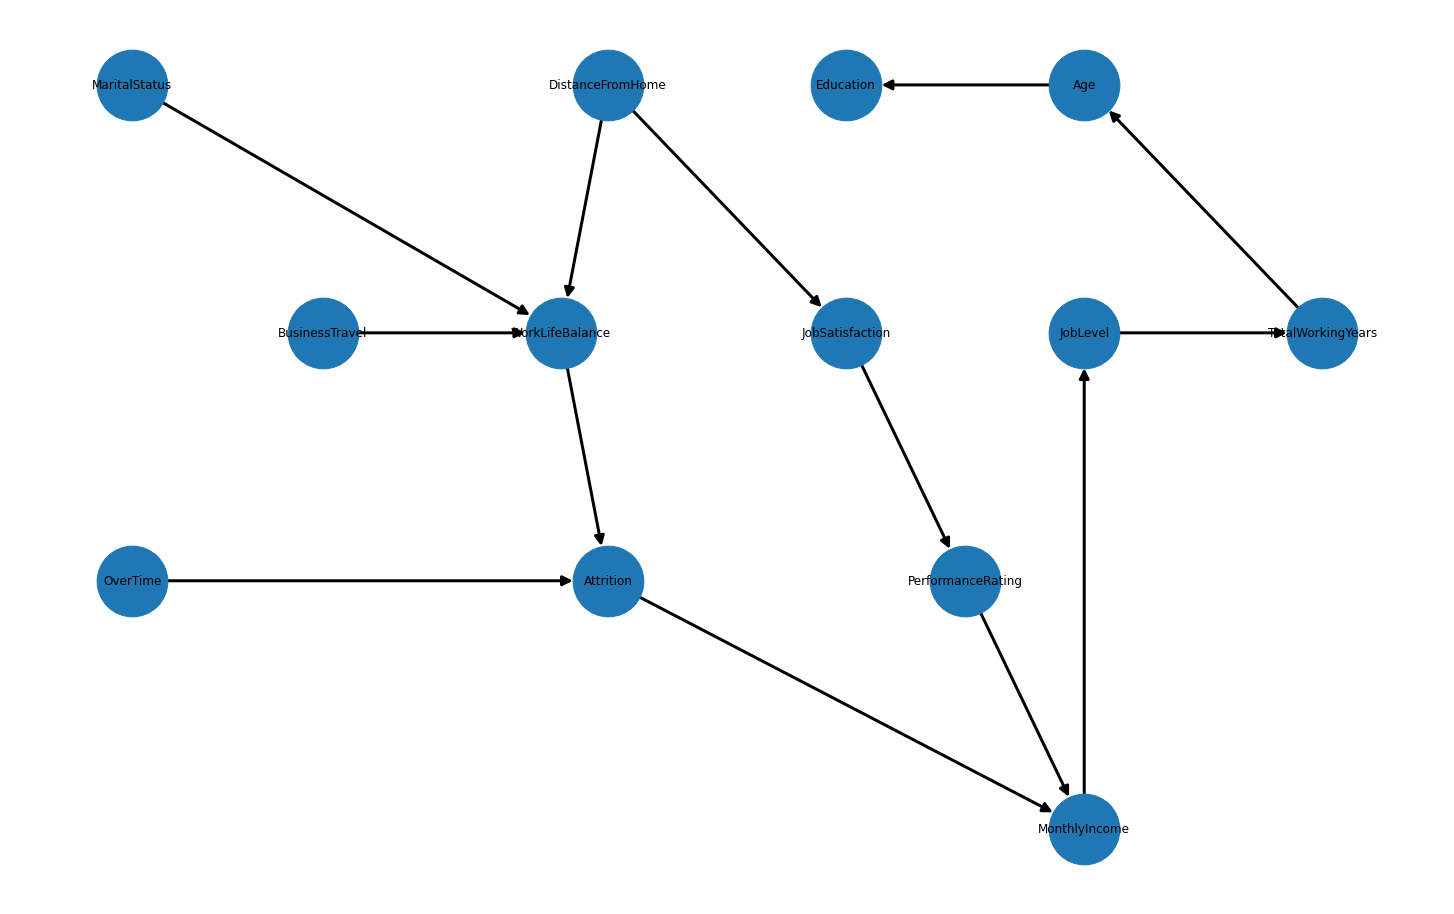

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
model_fixed_edges = est.estimate(scoring_method=BicScore(df),fixed_edges= edges)
nx.draw(model_fixed_edges, pos = pos,with_labels=True,node_size=5000, width=3, arrowsize=20)
print((model_fixed_edges.edges())-edges)
print(BicScore(df).score(model_fixed_edges))

## Using fixed edges, Hill Climbing K2 Score

  0%|          | 0/1000000 [00:00<?, ?it/s]

{('JobLevel', 'TotalWorkingYears'), ('MonthlyIncome', 'JobLevel'), ('MaritalStatus', 'Attrition'), ('MonthlyIncome', 'TotalWorkingYears'), ('TotalWorkingYears', 'Age'), ('Age', 'Education'), ('Attrition', 'MonthlyIncome')}
-17060.4498482915


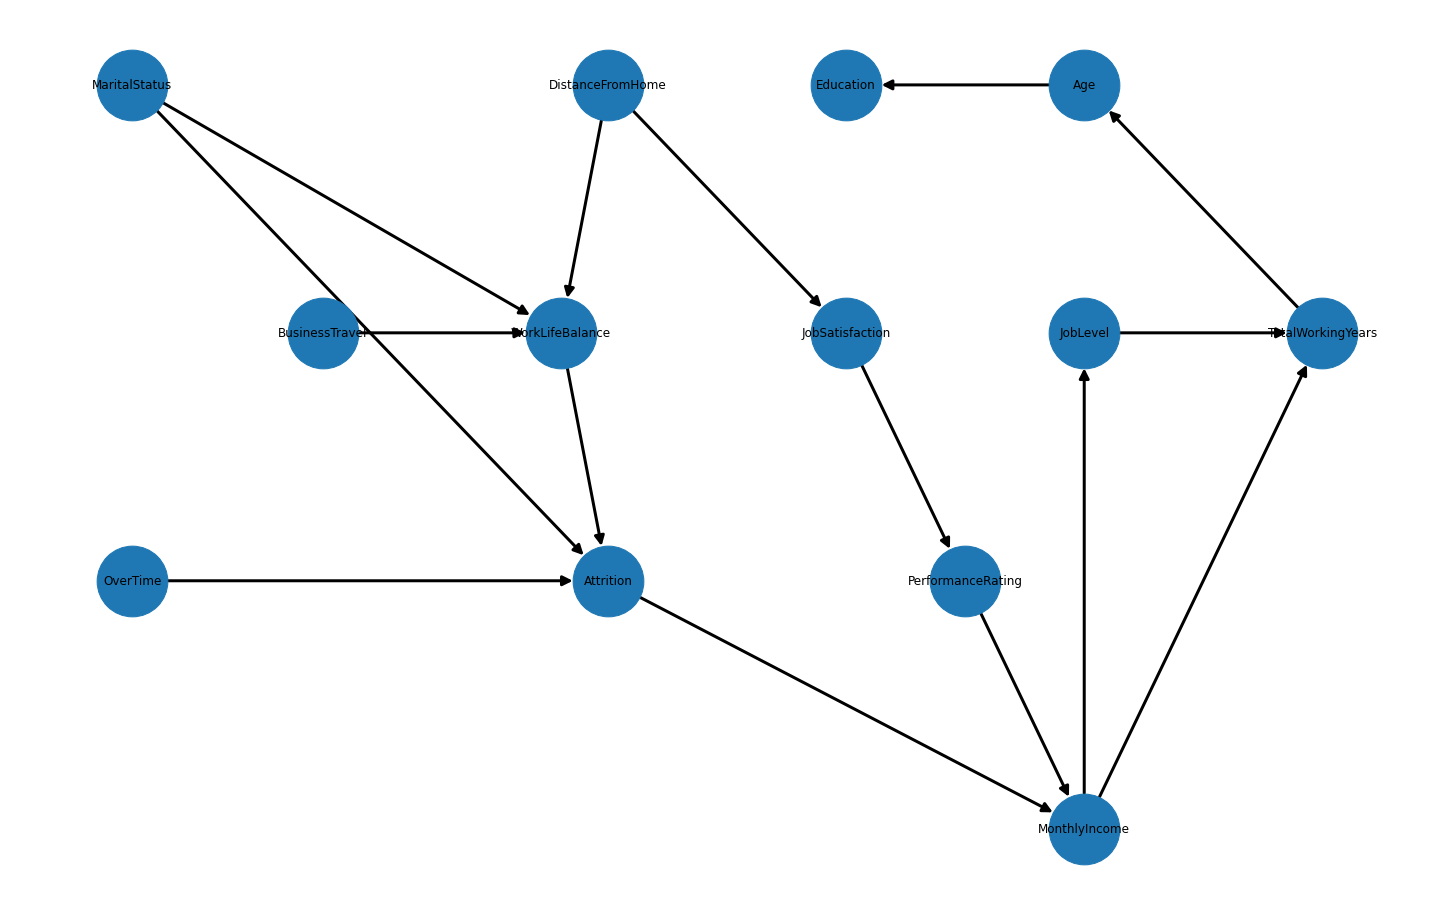

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
model_fixed_edges_K2 = est.estimate(scoring_method=K2Score(df),fixed_edges= edges)
nx.draw(model_fixed_edges_K2, pos = pos,with_labels=True,node_size=5000, width=3, arrowsize=20)
print((model_fixed_edges_K2.edges())-edges)
print(K2Score(df).score(model_fixed_edges_K2))


### Observation
Using fixed nodes, we can observed that there is an improvement on the network structure as it possible to observe from BicScore and K2Score parameters. However, in both network we do not have complete causal reasoning since the formula written below is not respected at all: <br><br>X -> Y if only if Y = f(V) where X belongs to V
 <br> <br>
 For example there is an edge from TotalWorkingYears to age and this doesn't respect the structural equation.
 <br>
To have a causal reasoning we use a black list as a parameter of the estimate function. The black list is obtained from the ordered list, it avoids getting edges which do not respect the ordered imposed


## Using Ordered List to improve final Result

In [16]:
# Using black list
black_list = []
for i in range(0,len(orderd_list)):
    for j in range(0,i):
        black_list.append((orderd_list[i],orderd_list[j]))

### Using fixed edges and black list, Hill Climbing BicScore



  0%|          | 0/1000000 [00:00<?, ?it/s]

{('Age', 'TotalWorkingYears'), ('TotalWorkingYears', 'JobLevel'), ('JobLevel', 'MonthlyIncome'), ('Age', 'Education')}
-17323.842177371484


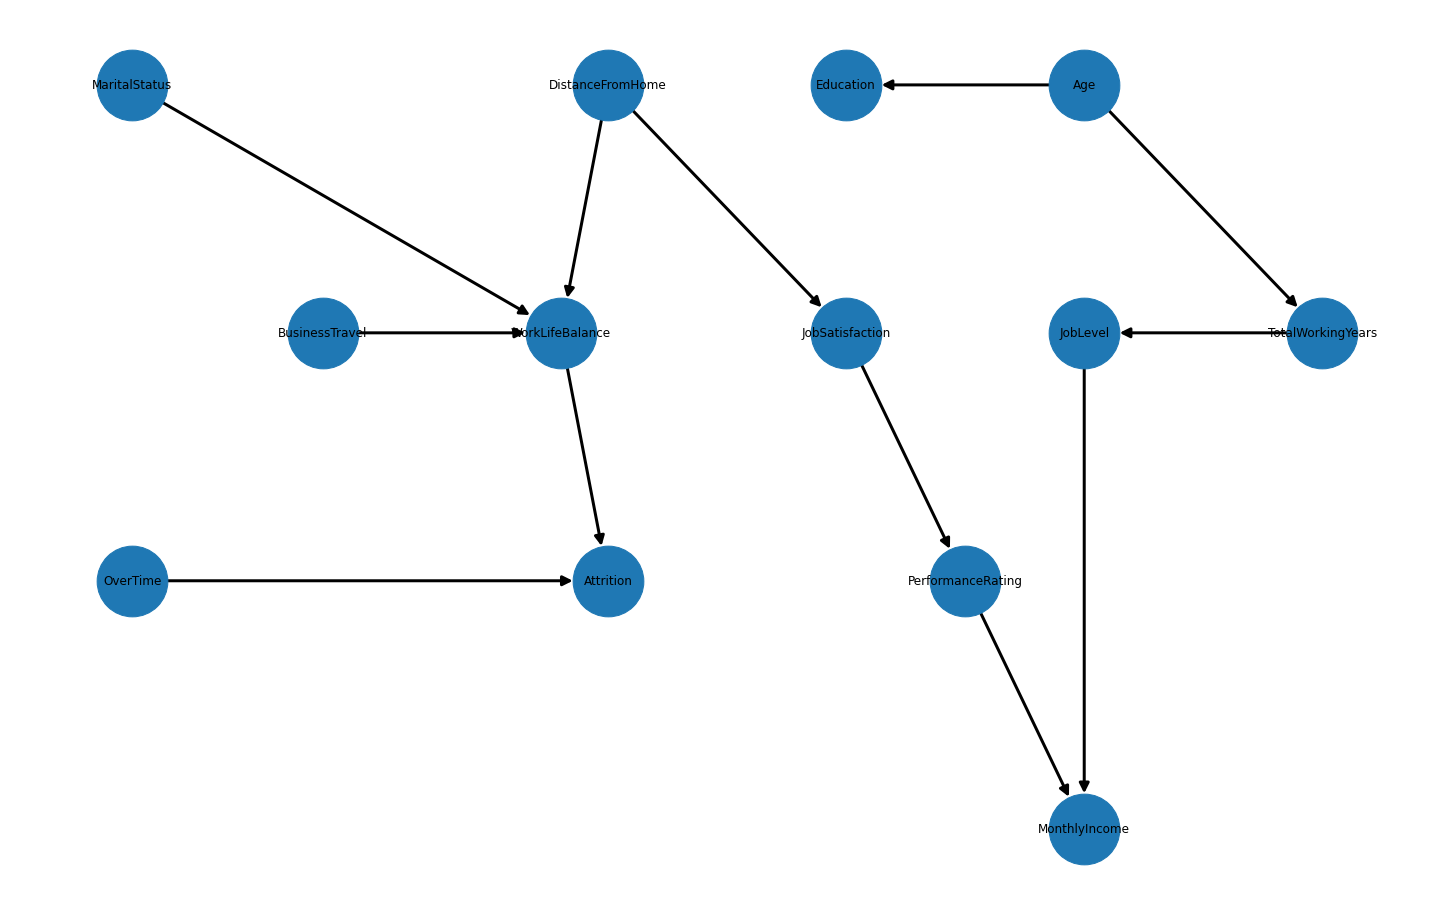

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
last_model_bic = HillClimbSearch(df)
last_model_bic = est.estimate(scoring_method=BicScore(df),fixed_edges=edges, black_list=black_list)
nx.draw(last_model_bic, pos = pos,with_labels=True,node_size=5000, width=3, arrowsize=20)
print((last_model_bic.edges())-edges)
print(BicScore(df).score(last_model_bic))

### Using fixed edges and black list, Hill Climbing K2Score


  0%|          | 0/1000000 [00:00<?, ?it/s]

{('MonthlyIncome', 'Attrition'), ('Age', 'TotalWorkingYears'), ('JobLevel', 'MonthlyIncome'), ('TotalWorkingYears', 'JobLevel'), ('Age', 'Education')}
-17085.786755285364


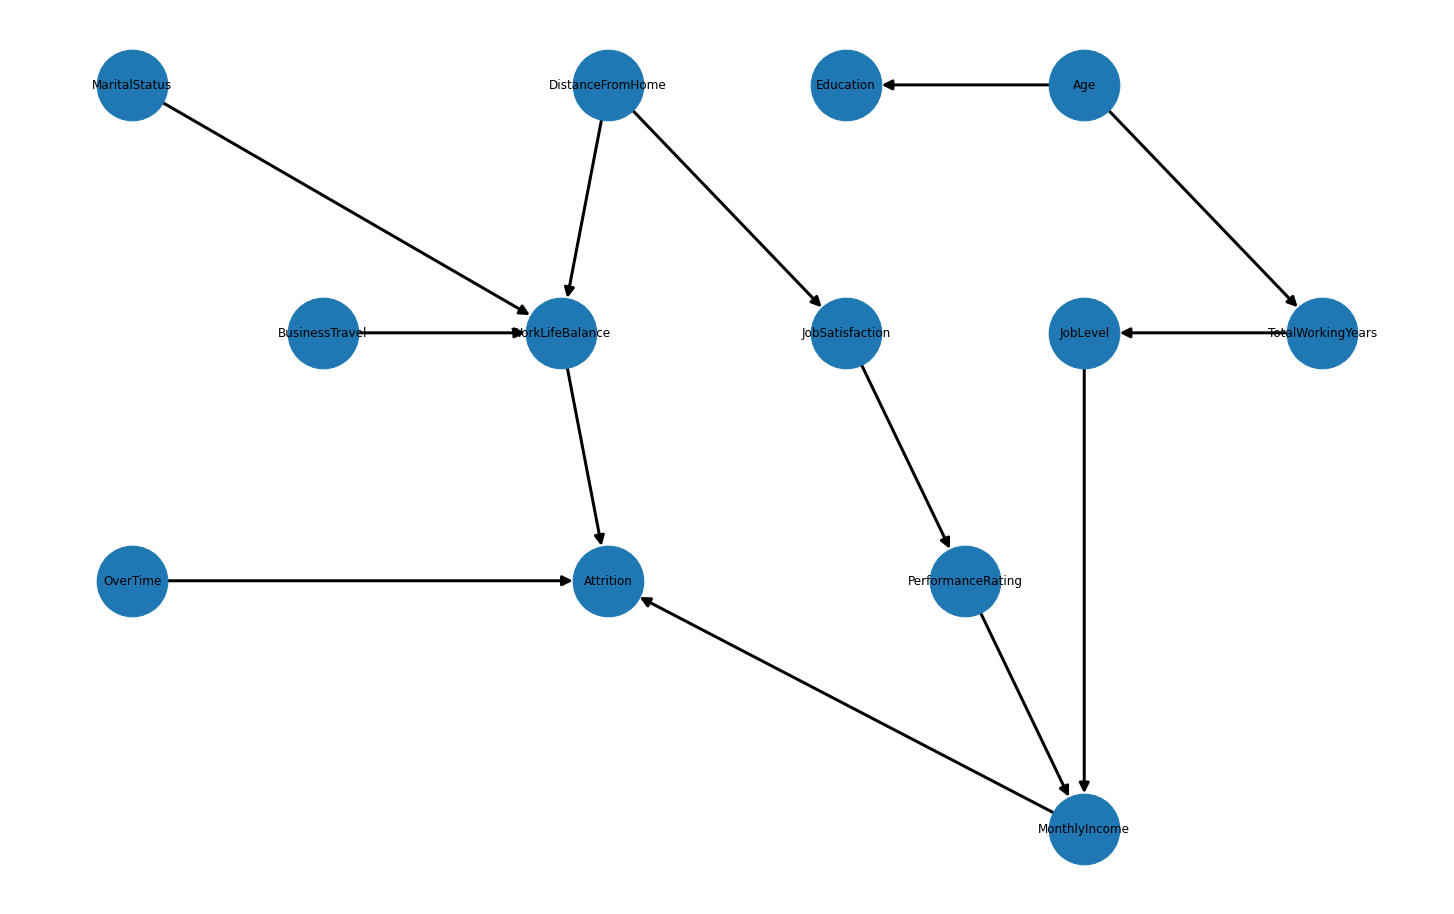

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
last_model_K2 = est.estimate(scoring_method=K2Score(df),fixed_edges=edges, black_list=black_list)
nx.draw(last_model_K2,pos = pos, with_labels=True,node_size=5000, width=3, arrowsize=20)
print((last_model_K2.edges())-edges)
print(K2Score(df).score(last_model_K2))

### Observation
We can notice that using fixed edges and black list there are little improvement as reported from the 2 parameters.<br>
In these models the network structure has causal reasoning and it contains much information that could be used to do some inference.<br><br>
We use the BicScore model for the following experiments because of the better value. 


## CPD
To fit the model, it has been used two different estimators: <ul>
<li>MaximumLikelihoodEstimator The parameter values are found such that they maximize the likelihood that the process described by the model produced the data that were actually observed.
<li>BayesianEstimator is a function of observable random variables. Given observable variables X1 X2…Xn <br>
Your data may be able to be represented by the function f(x|θ), where θ is a prior distribution. However, you don’t know the actual value of θ, so you have to estimate it. An estimator of θ is a real valued function δ(X1… Xn) <br>
The loss function L(θ, a) where a belongs to R, is also a real valued function of θ. Our estimate here is a, and L(θ, a) tells us how much we lose by using a as an estimate when the true, real value of a parameter is θ.



### Likelihood

In [19]:
bn_likelihood = BayesianNetwork(last_model_bic.edges())
bn_likelihood.fit(df, estimator=MaximumLikelihoodEstimator)
cpds = bn_likelihood.get_cpds()
for cpd in cpds:
    print(cpd)

+-----------------+----------+
| Age(Middle-age) | 0.423129 |
+-----------------+----------+
| Age(Senior)     | 0.355102 |
+-----------------+----------+
| Age(Young)      | 0.221769 |
+-----------------+----------+
+-------------------------------+-----+---------------------+
| Age                           | ... | Age(Young)          |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Beginner)   | ... | 0.4723926380368098  |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Competent)  | ... | 0.27300613496932513 |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Expert)     | ... | 0.0                 |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Novice)     | ... | 0.254601226993865   |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Proficient) | ... | 0.0                 |
+-------------------------------+-----+

### Bayesian Estimator
If we observed the CPD of Likelihood estimator, we can notice that there are some probabilities equal to 0. <br>This problem is solved by BayesianEstimator because it uses the pseudocounts.<br>
Pseudocounts started by prior kowledge and adding information using smoothing, this avoid to have probabilities equal to 0.

In [20]:
bn_bayesian = BayesianNetwork(last_model_bic.edges())
bn_bayesian.fit(df, estimator=BayesianEstimator)
cpds = bn_bayesian.get_cpds()
for cpd in cpds:
    print(cpd)

+-----------------+----------+
| Age(Middle-age) | 0.422825 |
+-----------------+----------+
| Age(Senior)     | 0.355028 |
+-----------------+----------+
| Age(Young)      | 0.222147 |
+-----------------+----------+
+-------------------------------+-----+----------------------+
| Age                           | ... | Age(Young)           |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Beginner)   | ... | 0.47100712105798576  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Competent)  | ... | 0.2726347914547304   |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Expert)     | ... | 0.001017293997965412 |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Novice)     | ... | 0.25432349949135297  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Proficient) | ... | 0.001017293997965412 |
+--------------------------

## Number of parameters of last network

In [24]:
num_param = lambda model: sum([len(cpd.get_values().ravel()) for cpd in model.get_cpds()])
print('Number of parameters:',format(num_param(bn_bayesian)))

Number of parameters: 232


## DIPENDENT AND INDIPENDENT r.v.

### Dipendent and indipendent r.v. based on chi square test

In [21]:
col_names = df.columns 

display(pd.DataFrame(p_values, columns=col_names, index=col_names)>0.01)
corr = pd.DataFrame(p_values, columns=col_names, index=col_names)

dip = []
indip = []
for i in range(len(orderd_list)):
    c = orderd_list[i]
    for j in range(i+1, len(orderd_list)):
        r = orderd_list[j]    
        if corr[c][r]<0.01:
            dip.append(c + ' -> ' + r)
        else:
            indip.append(c + ' ⫫ ' + r)

print('Dipendent variables \n',*dip,sep='\n')
print('\n\nIndipendent variables \n',*indip,sep='\n')
        



,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PerformanceRating,TotalWorkingYears,WorkLifeBalance
Age,False,False,True,True,False,False,True,False,False,True,True,False,True
Attrition,False,False,False,True,True,False,False,False,False,False,True,False,False
BusinessTravel,True,False,False,True,True,True,True,True,True,True,True,True,True
DistanceFromHome,True,True,True,False,True,True,True,True,True,True,True,True,True
Education,False,True,True,True,False,False,True,True,False,True,True,False,True
JobLevel,False,False,True,True,False,False,True,True,False,True,True,False,True
JobSatisfaction,True,False,True,True,True,True,False,True,True,True,True,True,True
MaritalStatus,False,False,True,True,True,True,True,False,True,True,True,False,True
MonthlyIncome,False,False,True,True,False,False,True,True,False,True,True,False,True
OverTime,True,False,True,True,True,True,True,True,True,False,True,True,True


Dipendent variables 

Age -> Education
Age -> MaritalStatus
Age -> TotalWorkingYears
Age -> JobLevel
Age -> MonthlyIncome
Age -> Attrition
Education -> TotalWorkingYears
Education -> JobLevel
Education -> MonthlyIncome
MaritalStatus -> TotalWorkingYears
MaritalStatus -> Attrition
BusinessTravel -> Attrition
WorkLifeBalance -> Attrition
TotalWorkingYears -> JobLevel
TotalWorkingYears -> MonthlyIncome
TotalWorkingYears -> Attrition
JobLevel -> MonthlyIncome
JobLevel -> Attrition
OverTime -> Attrition
JobSatisfaction -> Attrition
MonthlyIncome -> Attrition


Indipendent variables 

Age ⫫ DistanceFromHome
Age ⫫ BusinessTravel
Age ⫫ WorkLifeBalance
Age ⫫ OverTime
Age ⫫ JobSatisfaction
Age ⫫ PerformanceRating
Education ⫫ MaritalStatus
Education ⫫ DistanceFromHome
Education ⫫ BusinessTravel
Education ⫫ WorkLifeBalance
Education ⫫ OverTime
Education ⫫ JobSatisfaction
Education ⫫ PerformanceRating
Education ⫫ Attrition
MaritalStatus ⫫ DistanceFromHome
MaritalStatus ⫫ BusinessTravel
MaritalStatu

### Using last Network to find Active Trail and Conditional Indipendence



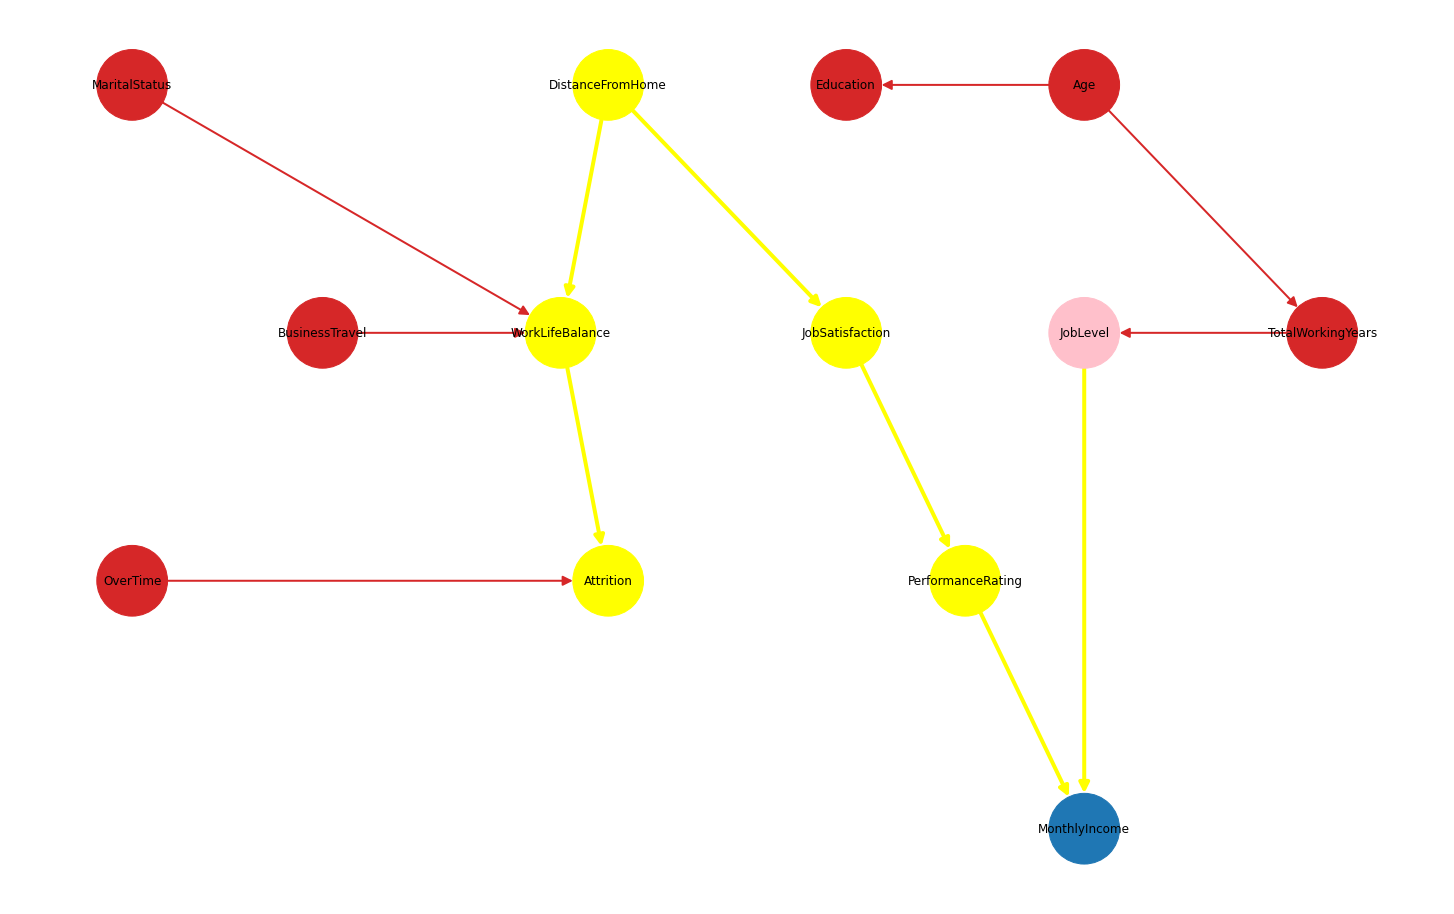

In [ ]:
def display_active_trails(net, target, evidence=[]):
    active_trail = net.active_trail_nodes(target, evidence)[target]
    # blue if target, pink if evidence, yellow if in trails active, red otherwise
    nodes_colors = []
    for node in net.nodes():
        if node == target:
            nodes_colors.append("tab:blue")
        elif node in evidence:
            nodes_colors.append("pink")
        elif node in active_trail:
            nodes_colors.append("yellow")
        else:
            nodes_colors.append("tab:red")

    
    edges_colors = []
    edges_weights = []
    for (u, v) in net.edges:
        if u in active_trail and (v in active_trail or v in evidence):
            edges_colors.append("yellow")
            edges_weights.append(4)
        elif u in evidence and v == target:
            edges_colors.append("yellow")
            edges_weights.append(4)
        else:
            edges_colors.append("tab:red")
            edges_weights.append(2)

    # Plotting
    plt.figure(figsize=(20,12.5))
    nx.draw(net,pos = pos, width=edges_weights,
            node_color=nodes_colors, edge_color=edges_colors,
            with_labels=True, node_size=5000, arrowsize=20)


display_active_trails(bn_likelihood, 'MonthlyIncome',evidence =['JobLevel'])

In [ ]:
def draw_indipendence(net,first_node,second_node,evidence = []):
    ancenstors = []
    for ev in evidence:
        ancenstors.append(net._get_ancestors_of(ev))
    
    ancestors = set().union(*ancenstors)
    nodes_colors = []
    for node in net.nodes():
        if node == first_node or node == second_node:
            nodes_colors.append("blue")
        elif node in evidence:
            nodes_colors.append("red")
        elif node in ancestors:
            nodes_colors.append("yellow")
        else:
            nodes_colors.append("green")
    plt.figure(figsize=(20,12.5))
    
    nx.draw_networkx(net,pos = pos,
            node_color=nodes_colors,
            with_labels=True, node_size=5000, arrowsize=20,label = 'Ciao')

def is_indipendent(net,first_node,second_node,evidence = []):
    active_trail = net.active_trail_nodes(first_node,evidence)[first_node]
    if second_node in active_trail:
        return 'Dipendent'
    return 'Indipendent'


'Indipendent'

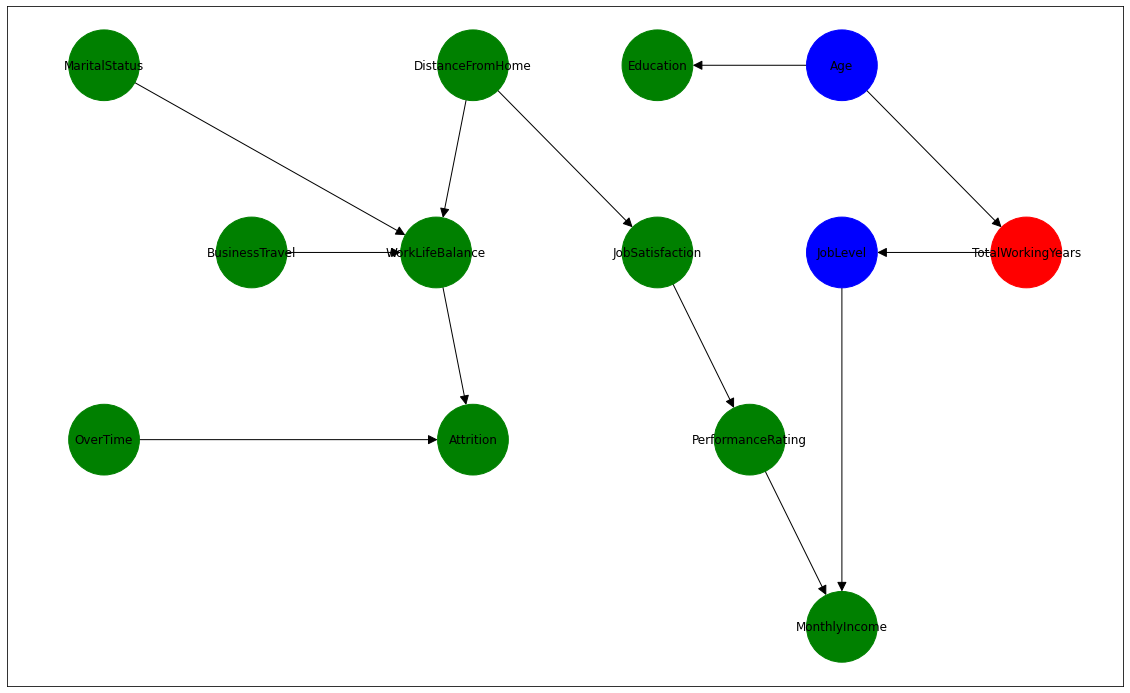

In [ ]:
draw_indipendence(bn_likelihood,'Age','JobLevel',evidence = ['TotalWorkingYears'])
is_indipendent(bn_likelihood,'Age','JobLevel',evidence = ['TotalWorkingYears'])

'Dipendent'

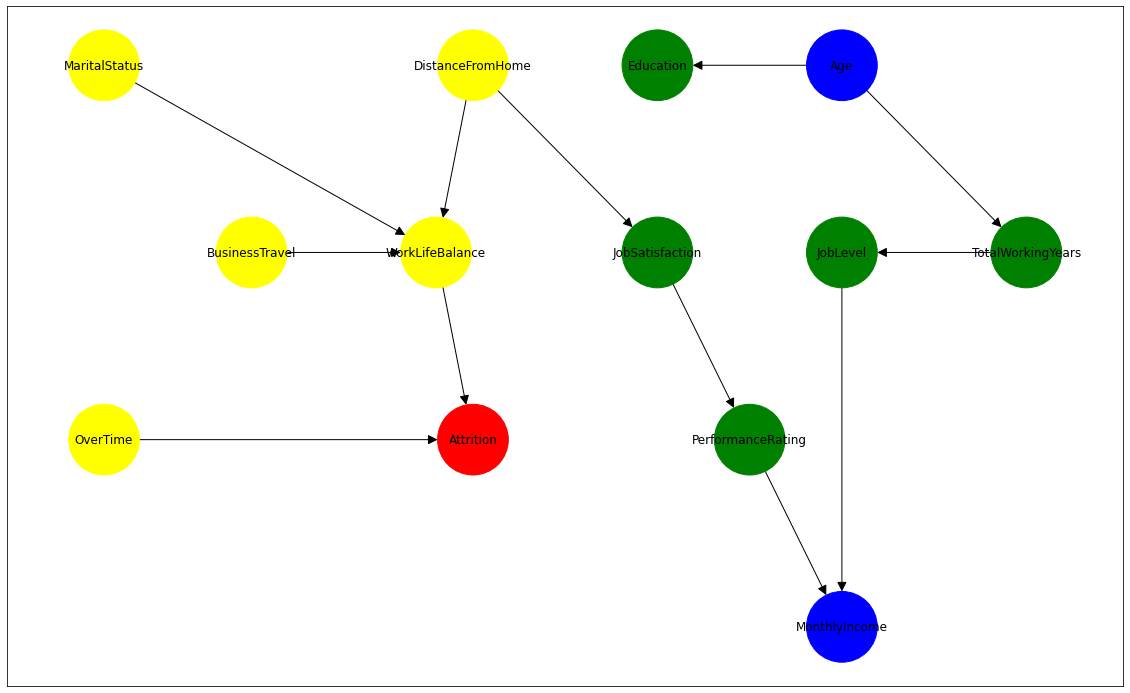

In [ ]:
draw_indipendence(bn_likelihood,'Age','MonthlyIncome',evidence = ['Attrition'])
is_indipendent(bn_likelihood,'Age','MonthlyIncome',evidence = ['Attrition'])

'Indipendent'

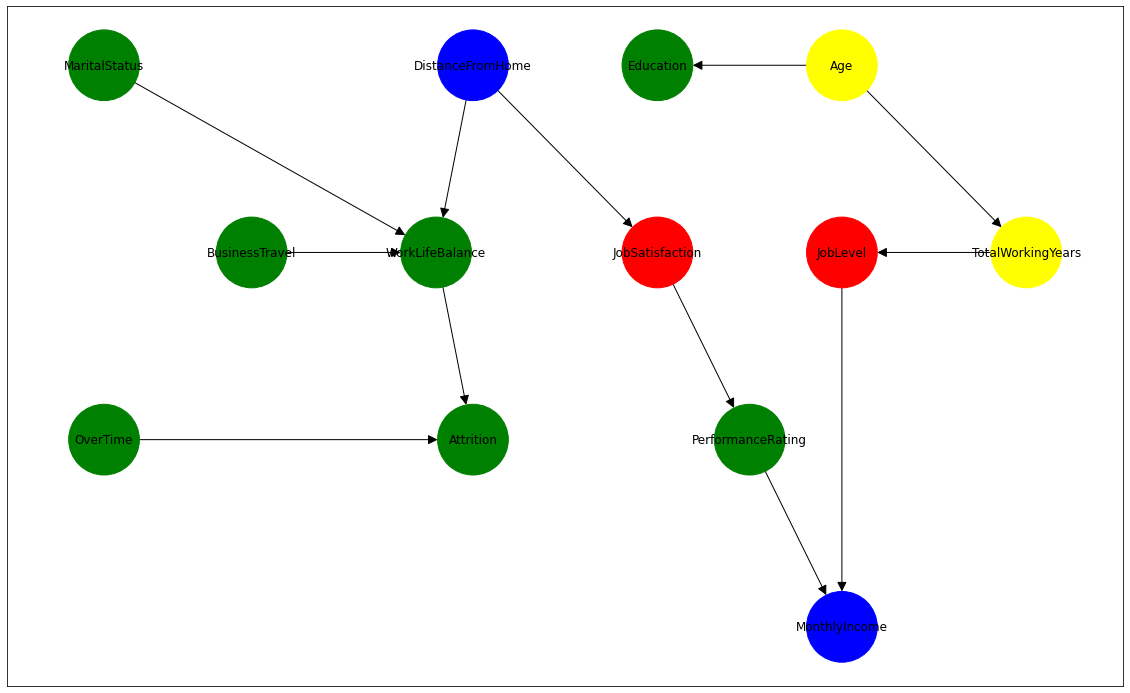

In [ ]:
draw_indipendence(bn_likelihood,'MonthlyIncome','DistanceFromHome',evidence = ['JobSatisfaction','JobLevel'])
is_indipendent(bn_likelihood,'MonthlyIncome','DistanceFromHome',evidence = ['JobSatisfaction','JobLevel'])

'Dipendent'

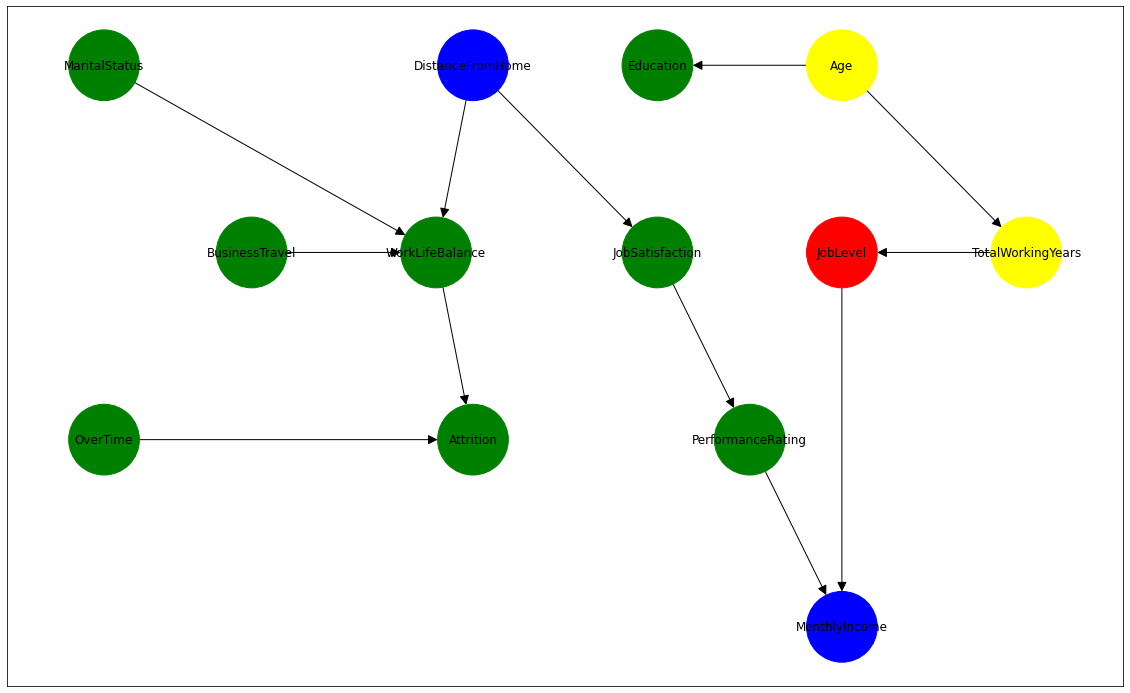

In [ ]:
draw_indipendence(bn_likelihood,'MonthlyIncome','DistanceFromHome',evidence = ['JobLevel'])
is_indipendent(bn_likelihood,'MonthlyIncome','DistanceFromHome',evidence = ['JobLevel'])

'Indipendent'

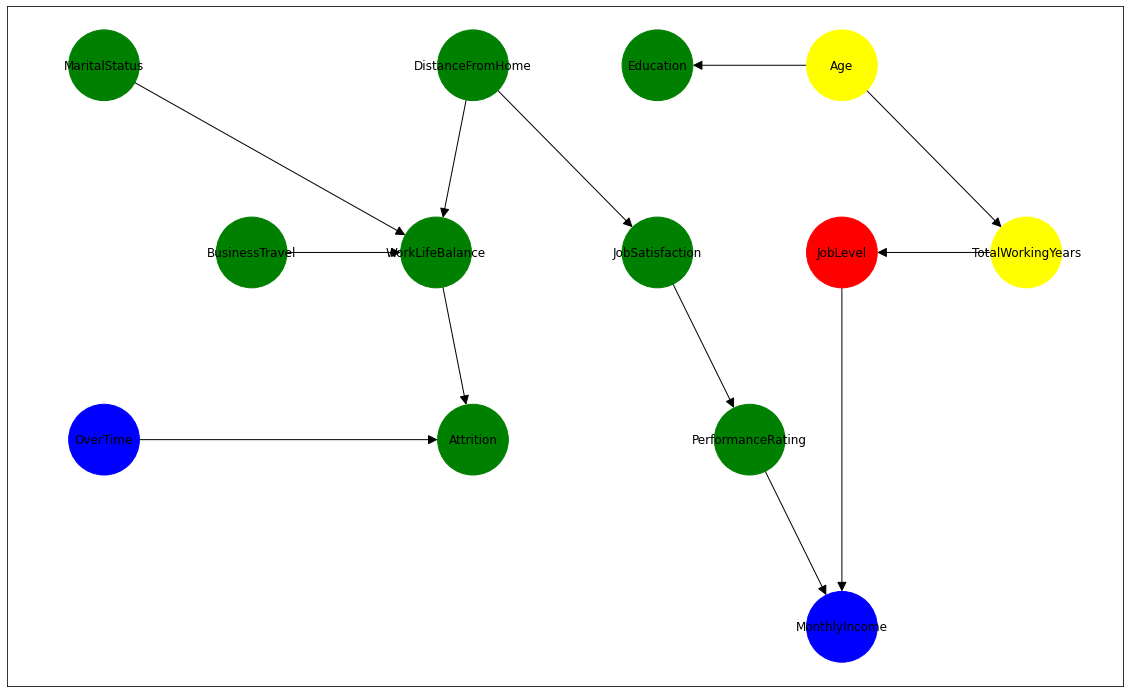

In [ ]:
draw_indipendence(bn_likelihood, 'MonthlyIncome', 'OverTime',['JobLevel'])
is_indipendent(bn_likelihood, 'MonthlyIncome', 'OverTime',['JobLevel'])

## Exact Inference

### likelihood
This queries shows that using the likelihood estimator we get 0-probabilities

If the job level is Manager we have the probability equals 1 to have an higher salary, this problem it has been reported in the last section

In [ ]:
infer = VariableElimination(bn_likelihood)
print("P(MonthlyIncome | JobLevel = Rappresentative)")
print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Rappresentative'}))
print("P(MonthlyIncome | JobLevel = Manager)")
print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Manager'}))

P(MonthlyIncome | JobLevel = Rappresentative)
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.1853 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0450 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.7697 |
+---------------------------+----------------------+
P(MonthlyIncome | JobLevel = Manager)
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               1.0000 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0000 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.0000 |
+--------------

### Bayesian Estimator
Using this estimator, we do not have probabilities equal to 0.

In [25]:
infer = VariableElimination(bn_bayesian)
print("P(MonthlyIncome | JobLevel = Rappresentative)")
print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Rappresentative'}))
print("P(MonthlyIncome | JobLevel = Manager)")

print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Manager'}))

P(MonthlyIncome | JobLevel = Rappresentative)
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.1856 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0457 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.7687 |
+---------------------------+----------------------+
P(MonthlyIncome | JobLevel = Manager)
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.9951 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0024 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.0024 |
+--------------


### Causal Inference


In [ ]:
print("P(MonthlyIncome | TotalWorkingYears = Proficient, JobSatisfaction = High )")
print(infer.query(['MonthlyIncome'], evidence={'TotalWorkingYears':'Proficient', 'JobSatisfaction':'High'}))


print("P(MonthlyIncome | TotalWorkingYears = Beginner, JobSatisfaction = Low )")
print(infer.query(['MonthlyIncome'], evidence={'TotalWorkingYears':'Beginner', 'JobSatisfaction':'Low'}))

print("P(MonthlyIncome | PerformanceRating = Excellent, Education = Below_college )")
print(infer.query(['MonthlyIncome'],evidence={'PerformanceRating':'Excellent', 'Education':'Below_college'}))

print("P(Attrition | DistanceFromHome = Short, OverTime = No )")
print(infer.query(['Attrition'],evidence={'DistanceFromHome':'Short', 'OverTime':'No'}))

P(MonthlyIncome | TotalWorkingYears = Proficient, JobSatisfaction = High )
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.4207 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.1338 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.4455 |
+---------------------------+----------------------+
P(MonthlyIncome | TotalWorkingYears = Beginner, JobSatisfaction = Low )
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.0621 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.5933 |
+---------------------------+----------------------+
| Mon

### Evidencial Inference

In [ ]:
print("P(Age | MonthlyIncome = Higher )")
print(infer.query(['Age'],evidence = {'MonthlyIncome':'Higher'}))

print("P(DistanceFromHome | OverTime = Yes, JobSatisfaction = Medium)")
print(infer.query(['DistanceFromHome'],evidence={'OverTime':'Yes','JobSatisfaction':'Medium'}))

print("P(Education | JobLevel = Director )")
print(infer.query(['Education'],evidence={'JobLevel':'Director'}))

P(Age | MonthlyIncome = Higher )
+-----------------+------------+
| Age             |   phi(Age) |
+=================+============+
| Age(Middle-age) |     0.3357 |
+-----------------+------------+
| Age(Senior)     |     0.5898 |
+-----------------+------------+
| Age(Young)      |     0.0745 |
+-----------------+------------+
P(DistanceFromHome | OverTime = Yes, JobSatisfaction = Medium)
+--------------------------+-------------------------+
| DistanceFromHome         |   phi(DistanceFromHome) |
+==========================+=========================+
| DistanceFromHome(Long)   |                  0.1508 |
+--------------------------+-------------------------+
| DistanceFromHome(Medium) |                  0.1970 |
+--------------------------+-------------------------+
| DistanceFromHome(Short)  |                  0.6521 |
+--------------------------+-------------------------+
P(Education | JobLevel = Director )
+--------------------------+------------------+
| Education                |

### Intercausal Inference (explaining away)

In [26]:
print('P(JobLevel | MonthlyIncome = Lower, PerformanceRating = Outstanding)')
print(infer.query(['JobLevel'],evidence = {'MonthlyIncome':'Lower', 'PerformanceRating':'Outstanding'}))

print("P(OverTime |WorkLifeBalance = Bad, Attrition = No)")
print(infer.query(['OverTime'],evidence = {'WorkLifeBalance':'Bad', 'Attrition':'No'}))

P(JobLevel | MonthlyIncome = Lower, PerformanceRating = Outstanding)
+---------------------------+-----------------+
| JobLevel                  |   phi(JobLevel) |
+===========================+=================+
| JobLevel(Director)        |          0.0026 |
+---------------------------+-----------------+
| JobLevel(Manager)         |          0.0027 |
+---------------------------+-----------------+
| JobLevel(Rappresentative) |          0.0534 |
+---------------------------+-----------------+
| JobLevel(Technician)      |          0.9413 |
+---------------------------+-----------------+
P(OverTime |WorkLifeBalance = Bad, Attrition = No)
+---------------+-----------------+
| OverTime      |   phi(OverTime) |
+===============+=================+
| OverTime(No)  |          0.7741 |
+---------------+-----------------+
| OverTime(Yes) |          0.2259 |
+---------------+-----------------+


## Approximate Inference
In this section we are going to study the time performances in sampling first with no evidences and after with them using the methods studied during the course: 

*   Rejection Sampling
*   Likelihood-wighted sampling




In [ ]:
infer_approx = ApproxInference(bn_bayesian)
sampling = BayesianModelSampling(bn_bayesian)


n_samples = [10,100,500,df.shape[0],1550] # 1700 = oversampling
evidences = [("TotalWorkingYears","Proficient"),("JobSatisfaction","High")]
query = ["MonthlyIncome"]

In [ ]:
for sample in n_samples:
  print('Sampling for ',sample)

  start = time()
  sampling.rejection_sample(size=sample)
  trne = time() - start

  start = time()
  sampling.likelihood_weighted_sample(size=sample)
  tlne = time() - start

  start = time()
  sampling.rejection_sample(evidences, size=sample)
  tr = time() - start

  start = time()
  sampling.likelihood_weighted_sample(evidences, size=sample)
  tl = time() - start

  print(f"Time for rejection sampling without evidence: {trne:.4f} seconds")
  print(f"Time for likelihood sampling without evidence: {tlne:.4f} seconds")
  print(f"Time for rejection sampling with evidence: {tr:.4f} seconds")
  print(f"Time for likelihood sampling with evidence: {tl:.4f} seconds")
    


Sampling for  10


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Time for rejection sampling without evidence: 0.1501 seconds
Time for likelihood sampling without evidence: 0.1677 seconds
Time for rejection sampling with evidence: 0.2836 seconds
Time for likelihood sampling with evidence: 0.1633 seconds
Sampling for  100


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Time for rejection sampling without evidence: 0.1616 seconds
Time for likelihood sampling without evidence: 0.1667 seconds
Time for rejection sampling with evidence: 0.2767 seconds
Time for likelihood sampling with evidence: 0.1504 seconds
Sampling for  500


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Time for rejection sampling without evidence: 0.1636 seconds
Time for likelihood sampling without evidence: 0.1554 seconds
Time for rejection sampling with evidence: 0.4360 seconds
Time for likelihood sampling with evidence: 0.1785 seconds
Sampling for  1470


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Time for rejection sampling without evidence: 0.1829 seconds
Time for likelihood sampling without evidence: 0.1856 seconds
Time for rejection sampling with evidence: 1.0851 seconds
Time for likelihood sampling with evidence: 0.1713 seconds
Sampling for  1550


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Time for rejection sampling without evidence: 0.1652 seconds
Time for likelihood sampling without evidence: 0.1824 seconds
Time for rejection sampling with evidence: 0.7633 seconds
Time for likelihood sampling with evidence: 0.2178 seconds


First of all it's possible to observe that both of the methods perform in the same way in absence of evidences, whereas with them the likelihood sampling performs better because it does not have to reject any samples so the computatinal cost is lower.

### Showing queries performance

In [ ]:
print("Analyzing query:\nP(MonthlyIncome | TotalWorkingYears = Proficient, JobSatisfaction = High )\n")
for sample in n_samples:
    print("Query performance for n_sample= ",sample)
    start = time()
    query = infer_approx.query(['MonthlyIncome'], evidence={'TotalWorkingYears':'Proficient', 'JobSatisfaction':'High'}, n_samples = sample, show_progress = False)
    print(f"Time needed: {time() - start}")
    print(str(query) + "\n")

Analyzing query:
P(MonthlyIncome | TotalWorkingYears = Proficient, JobSatisfaction = High )

Query performance for n_sample=  10
Time needed: 0.10594606399536133
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.4000 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.1000 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.5000 |
+---------------------------+----------------------+

Query performance for n_sample=  100
Time needed: 0.13833093643188477
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.3700 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)   

As it's possible to observe with an increasing number of samples the probability converges to the exact one, in addition the computational cost increases proportionally with the number of samples used.

## Markov blanket

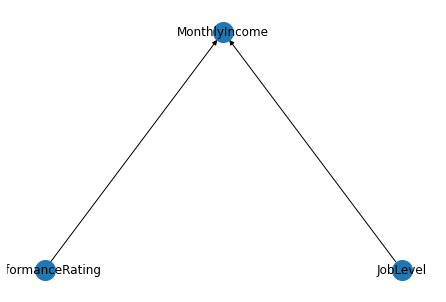

In [31]:
def markov_blanket(net, node):
    markov_nodes = net.get_markov_blanket(node)
    markov_nodes.append(node)
    markov_edges = [(e1, e2) for (e1, e2) in net.edges() if (e1 in markov_nodes) and (e2 in markov_nodes)]

    markov_blanket = DAG()
    markov_blanket.add_nodes_from(nodes=markov_nodes)
    markov_blanket.add_edges_from(ebunch=markov_edges)
    nx.draw_planar(markov_blanket,node_size=400, arrowsize=10, with_labels=True)

markov_blanket(bn_bayesian, "MonthlyIncome")